# Live FaceCam Analyser

#### import required packages

In [4]:
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

#### Importing and preprocessing Data

In [5]:
# Initialize image data generator with rescaling
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)

In [6]:
# Preprocess all test images
train_generator = train_gen.flow_from_directory(
        'data/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 21005 images belonging to 4 classes.


In [7]:
# Preprocess all train images
validation_generator = validation_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 5212 images belonging to 4 classes.


#### Preview of loaded Images

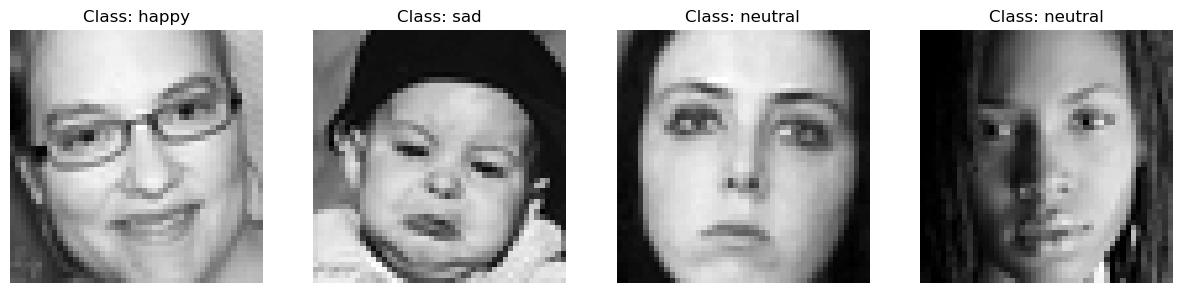

In [8]:
# Get the class indices
class_indices = validation_generator.class_indices

# Reverse the dictionary to map class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Preview an image from each class
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Get a batch of images for the current class
    images, labels = next(validation_generator)
    image = images[0]  # Take the first image from the batch
    label = class_labels[labels[0].argmax()]  # Get the label of the first image
    axes[i].imshow(image.squeeze(), cmap='gray')  # Display the image
    axes[i].set_title(f'Class: {label}')
    axes[i].axis('off')
plt.show()


#### Defining Structure of our CNN model

In [9]:
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(4, activation='softmax'))

#### Compiling and Training our model

In [10]:
cv2.ocl.setUseOpenCL(False)
from tensorflow.keras.optimizers import Adam
emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [11]:
# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=21005 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=5212 // 64)

C:\Users\rajat\AppData\Local\Temp\ipykernel_6092\2048131348.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


Epoch 1/10
328/328 [==============================] - 201s 609ms/step - loss: 1.3546 - accuracy: 0.3461 - val_loss: 1.3272 - val_accuracy: 0.3794
Epoch 2/10
328/328 [==============================] - 96s 292ms/step - loss: 1.2508 - accuracy: 0.4416 - val_loss: 1.1935 - val_accuracy: 0.4992
Epoch 3/10
328/328 [==============================] - 96s 292ms/step - loss: 1.1617 - accuracy: 0.4984 - val_loss: 1.1054 - val_accuracy: 0.5276
Epoch 4/10
328/328 [==============================] - 96s 292ms/step - loss: 1.0974 - accuracy: 0.5306 - val_loss: 1.0629 - val_accuracy: 0.5561
Epoch 5/10
328/328 [==============================] - 96s 291ms/step - loss: 1.0534 - accuracy: 0.5492 - val_loss: 1.0404 - val_accuracy: 0.5457
Epoch 6/10
328/328 [==============================] - 96s 292ms/step - loss: 1.0093 - accuracy: 0.5726 - val_loss: 0.9798 - val_accuracy: 0.5822
Epoch 7/10
328/328 [==============================] - 96s 293ms/step - loss: 0.9740 - accuracy: 0.5890 - val_loss: 0.9584 - val_a

#### Printing Training vs Validation Accuracy, Confusion Matrix and Classification report

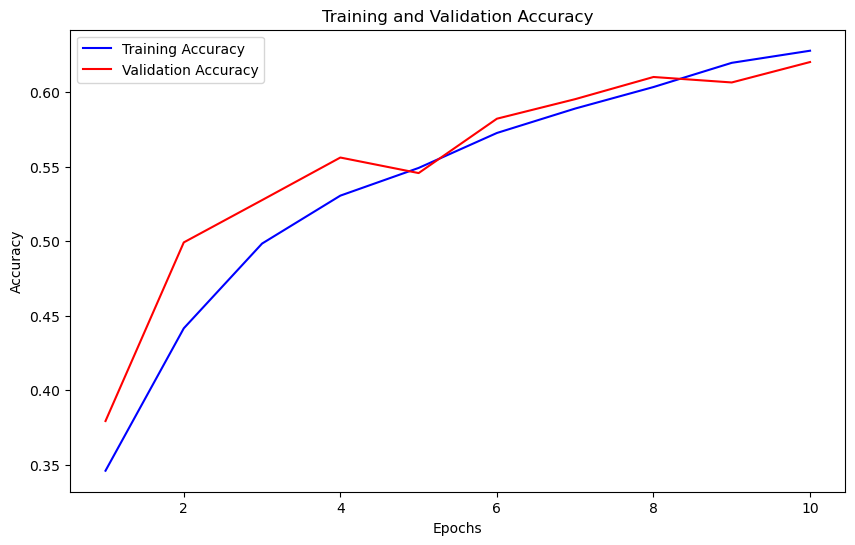

C:\Users\rajat\AppData\Local\Temp\ipykernel_6092\938894037.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(validation_generator)


[[160 363 234 201]
 [290 691 437 356]
 [207 503 286 237]
 [210 482 279 276]]


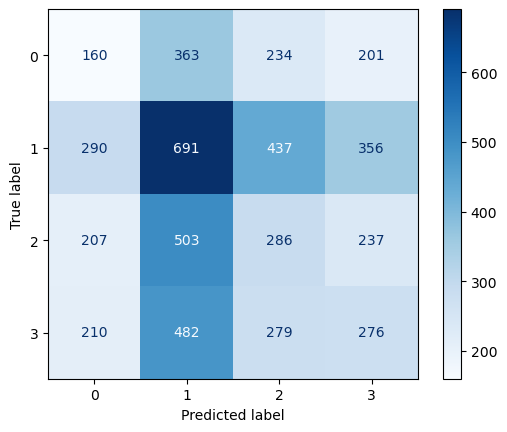

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.18      0.17      0.18       958
           1       0.34      0.39      0.36      1774
           2       0.23      0.23      0.23      1233
           3       0.26      0.22      0.24      1247

    accuracy                           0.27      5212
   macro avg       0.25      0.25      0.25      5212
weighted avg       0.27      0.27      0.27      5212



In [13]:
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}

# Get the training and validation accuracy from the model history
train_accuracy = emotion_model_info.history['accuracy']
val_accuracy = emotion_model_info.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


predictions = emotion_model.predict_generator(validation_generator)

# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1)))

#### Saving Our Model

In [18]:
# save model structure in json file
model_json = emotion_model.to_json()
with open("emotion_model_v2.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model_v2.h5')

#### Hyperparameter Tuning - v3

In [15]:
# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Initialize the model
emotion_model = Sequential()

# Add convolutional layers
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(4, activation='softmax'))

# Compile the model
emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=21005 // 64,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=5212 // 64,
        callbacks=[LearningRateScheduler(scheduler)])

C:\Users\rajat\AppData\Local\Temp\ipykernel_6092\914672363.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


Epoch 1/15
328/328 [==============================] - 311s 943ms/step - loss: 1.2861 - accuracy: 0.4108 - val_loss: 1.3074 - val_accuracy: 0.5052 - lr: 1.0000e-04
Epoch 2/15
328/328 [==============================] - 135s 412ms/step - loss: 1.1304 - accuracy: 0.5079 - val_loss: 1.0918 - val_accuracy: 0.5480 - lr: 1.0000e-04
Epoch 3/15
328/328 [==============================] - 123s 375ms/step - loss: 1.0445 - accuracy: 0.5484 - val_loss: 0.9749 - val_accuracy: 0.5862 - lr: 1.0000e-04
Epoch 4/15
328/328 [==============================] - 119s 362ms/step - loss: 0.9855 - accuracy: 0.5787 - val_loss: 0.9446 - val_accuracy: 0.5965 - lr: 1.0000e-04
Epoch 5/15
328/328 [==============================] - 111s 339ms/step - loss: 0.9388 - accuracy: 0.6051 - val_loss: 0.9004 - val_accuracy: 0.6177 - lr: 1.0000e-04
Epoch 6/15
328/328 [==============================] - 113s 343ms/step - loss: 0.8994 - accuracy: 0.6232 - val_loss: 0.8739 - val_accuracy: 0.6304 - lr: 1.0000e-04
Epoch 7/15
328/328 [==

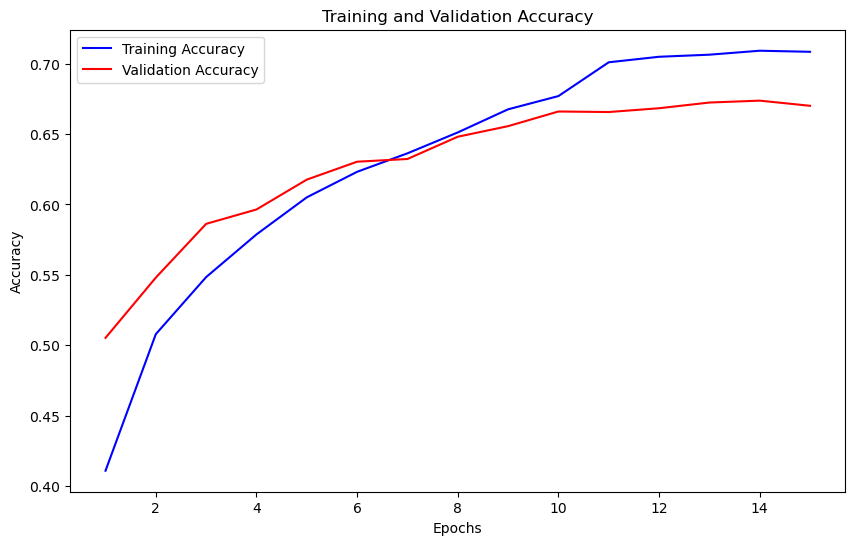

C:\Users\rajat\AppData\Local\Temp\ipykernel_6092\938894037.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(validation_generator)


[[145 351 215 247]
 [285 653 428 408]
 [219 481 257 276]
 [201 441 298 307]]


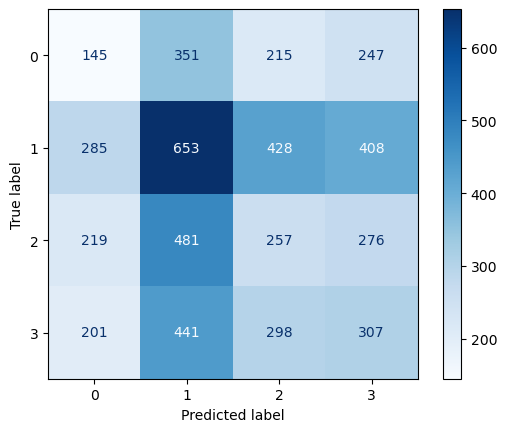

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.17      0.15      0.16       958
           1       0.34      0.37      0.35      1774
           2       0.21      0.21      0.21      1233
           3       0.25      0.25      0.25      1247

    accuracy                           0.26      5212
   macro avg       0.24      0.24      0.24      5212
weighted avg       0.26      0.26      0.26      5212



In [16]:
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}

# Get the training and validation accuracy from the model history
train_accuracy = emotion_model_info.history['accuracy']
val_accuracy = emotion_model_info.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


predictions = emotion_model.predict_generator(validation_generator)

# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1)))

In [39]:
# save model structure in json file
model_json = emotion_model.to_json()
with open("emotion_model_v3.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model_v3.h5')

#### Hyperparameter tunning v4

In [17]:
# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Initialize the model
emotion_model = Sequential()

# Add convolutional layers
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(4, activation='softmax'))

# Compile the model
emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=21005 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=5212 // 64,
        callbacks=[LearningRateScheduler(scheduler)])


Epoch 1/10


C:\Users\rajat\AppData\Local\Temp\ipykernel_6092\2817986070.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


328/328 [==============================] - 111s 335ms/step - loss: 1.3441 - accuracy: 0.3539 - val_loss: 1.3388 - val_accuracy: 0.3981 - lr: 1.0000e-04
Epoch 2/10
328/328 [==============================] - 105s 320ms/step - loss: 1.1993 - accuracy: 0.4564 - val_loss: 1.1229 - val_accuracy: 0.5017 - lr: 1.0000e-04
Epoch 3/10
328/328 [==============================] - 104s 317ms/step - loss: 1.0921 - accuracy: 0.5180 - val_loss: 1.0266 - val_accuracy: 0.5685 - lr: 1.0000e-04
Epoch 4/10
328/328 [==============================] - 104s 316ms/step - loss: 1.0332 - accuracy: 0.5534 - val_loss: 0.9732 - val_accuracy: 0.5963 - lr: 1.0000e-04
Epoch 5/10
328/328 [==============================] - 146s 447ms/step - loss: 0.9803 - accuracy: 0.5826 - val_loss: 0.9343 - val_accuracy: 0.6109 - lr: 1.0000e-04
Epoch 6/10
328/328 [==============================] - 111s 339ms/step - loss: 0.9437 - accuracy: 0.6019 - val_loss: 0.9347 - val_accuracy: 0.6001 - lr: 1.0000e-04
Epoch 7/10
328/328 [=============

In [35]:
# save model structure in json file
model_json = emotion_model.to_json()
with open("emotion_model_v4.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save_weights('emotion_model_v4.h5')

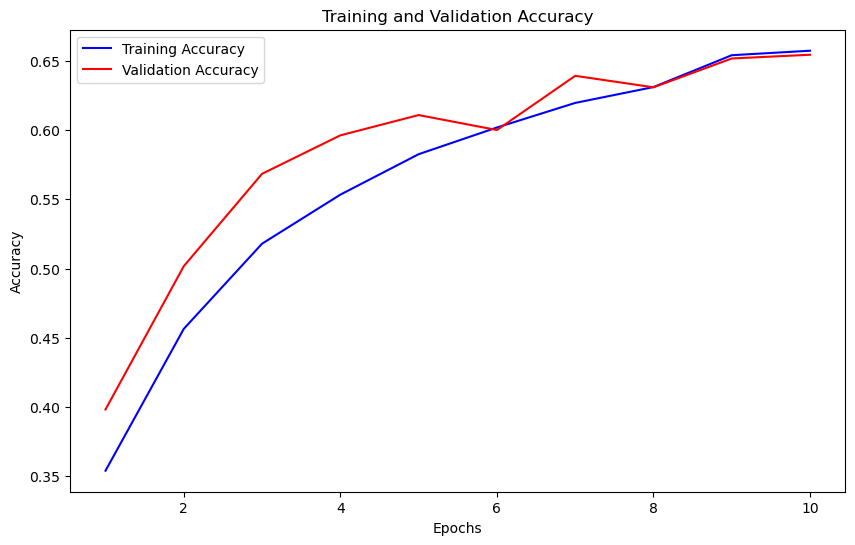

C:\Users\rajat\AppData\Local\Temp\ipykernel_6092\938894037.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(validation_generator)


[[122 336 188 312]
 [197 605 377 595]
 [132 435 246 420]
 [162 418 249 418]]


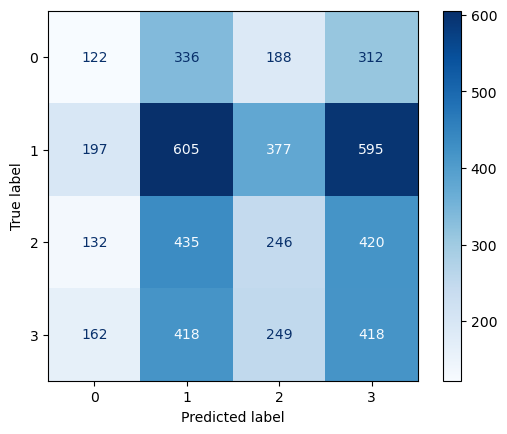

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.20      0.13      0.16       958
           1       0.34      0.34      0.34      1774
           2       0.23      0.20      0.21      1233
           3       0.24      0.34      0.28      1247

    accuracy                           0.27      5212
   macro avg       0.25      0.25      0.25      5212
weighted avg       0.26      0.27      0.26      5212



In [18]:
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}

# Get the training and validation accuracy from the model history
train_accuracy = emotion_model_info.history['accuracy']
val_accuracy = emotion_model_info.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


predictions = emotion_model.predict_generator(validation_generator)

# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1)))

#### Testing the model using our facecam

In [5]:
import cv2
import numpy as np
from keras.models import model_from_json


emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad"}

# load json and create model
j_file = open('emotion_model_v2.json', 'r')
model_json = j_file.read()
j_file.close()
emotion_model = model_from_json(model_json)

# load weights into new model
emotion_model.load_weights("emotion_model_v2.h5")
print("Loaded model from disk")

# start the webcam feed
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_detector = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

    # Preprocessing faces as per our data
    for (x, y, w, h) in face_detector:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

        # predict the emotions
        emotion_prediction = emotion_model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Loaded model from disk
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
